In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import random
import numpy as np
from collections import deque  # 双向队列
import torch.optim as optim
import gym

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
writer_policy_graph = SummaryWriter('sac_2019_humen/policy_net')
writer_softq_graph = SummaryWriter('sac_2019_humen/SoftQ_net')
writer_scale = SummaryWriter('sac_2019_humen')

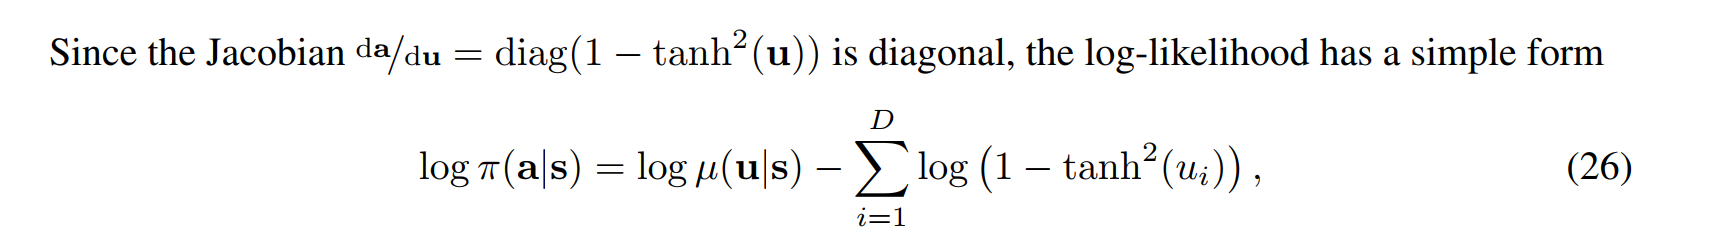
$\mu$ 是概率密度

In [4]:
class SoftQNetwork(nn.Module):
    '''Critic，多输入网络'''
    def __init__(self, num_inputs, num_actions, hidden_size=256):
        super(SoftQNetwork, self).__init__()
        self.l1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)  # 首先把两个输入合并一起
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return x
    
class PolicyNetwork(nn.Module):
    '''Actor，多输出网络'''
    def __init__(self, num_inputs, num_actions, hidden_size=256, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        self.log_std_min = log_std_min                              # 这两个咋来的
        self.log_std_max = log_std_max
        
        self.l1 = nn.Linear(num_inputs, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        
        self.l_mean = nn.Linear(hidden_size, num_actions)
        self.l_logstd = nn.Linear(hidden_size, num_actions)
        
    def forward(self, state):
        '''根据给定的state得到，mean和log_std'''
        x = torch.relu(self.l1(state))
        x = torch.relu(self.l2(x))
        
        mean = self.l_mean(x)
        log_std = self.l_logstd(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)  # torch的clip其实是clamp

        return mean, log_std
    
    def sample(self, state, epsilon=1e-6):
        '''根据state得到mean和logstd之后再计算action(-1,1)和log_pi，是式子26'''
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        u = normal.rsample()        # rsample()  :从normal高斯分布采样一个u, 形状和mean相同
        action = torch.tanh(u)      # action取tanh u
        
        log_pi = normal.log_prob(u) - torch.log(1 - action.pow(2) + epsilon) # (26)
        log_pi = log_pi.sum(1, keepdim=True)                                # 用.sum(dim, keep_dim)这个语法
        
        return action, log_pi

In [5]:
class BasicBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
        
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        
        batch = random.sample(self.buffer, batch_size)
        
        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
            
        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

In [6]:
def update_target(model, target_model, tau):
    for target_pam, pam in zip(target_model.parameters(), model.parameters()):
        target_pam.data.copy_((1. - tau) * target_pam + tau * pam)

In [7]:
class SAC_Agent:
    def __init__(self, env, gamma, tau, alpha, q_lr, policy_lr, a_lr, buffer_maxlen):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.env = env
        self.action_range = [self.env.action_space.low, self.env.action_space.high]
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        
        self.gamma = gamma
        self.tau = tau
        self.update_step = 0
        self.delay_step = 2
        
        ## 初始化网络
        self.policy_net = PolicyNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.q_net1 = SoftQNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.q_net2 = SoftQNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.target_q_net1 = SoftQNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.target_q_net2 = SoftQNetwork(self.obs_dim, self.action_dim).to(self.device)
        
        # 初始化目标网络的权重
        update_target(self.q_net1, self.target_q_net1, tau=1.)
        update_target(self.q_net2, self.target_q_net2, tau=1.)
        
        ## 优化器
        self.q1_optimizer = optim.Adam(self.q_net1.parameters(), lr=q_lr)
        self.q2_optimizer = optim.Adam(self.q_net2.parameters(), lr=q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        
        ## Q网络的损失函数
        self.loss_fn_q = nn.MSELoss()
        
        ## 自动熵
        self.alpha = alpha
        self.target_entropy = -torch.prod(torch.Tensor(self.env.action_space.shape).to(self.device)).item() #H
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=a_lr) # 单个训练变量的参数形式是列表
        
        # 经验池
        self.replay_buffer = BasicBuffer(buffer_maxlen)
        
        # 用来记录各种标量的字典
        self.summuries = {}
        
    def get_action(self, state):
        # FloatTensor是把列表或者数组直接转换成tensorfloat32的函数，unsqueeze(dim)是在指定位置插入新维度
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # 输入变量也都 to device
        mean, log_std = self.policy_net(state)  # 自动call forward
        std = log_std.exp()
        
        normal = Normal(mean, std)
        u = normal.sample()     # sample() 和 rsample() 有所不同，这个一般用于不参与梯度计算的时候
        
        action = torch.tanh(u)
        
        action = action.cpu().detach().squeeze(0).numpy()  # 需要转移到cpu上，不然显示不了这个值
        scaled_action = self.rescale_action(action)
        return scaled_action  # (-2,2)
        
    def test_get_action(self, state):
        # 去掉方差， 测试的时候，只用均值即可
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # 输入变量也都 to device
        mean, _ = self.policy_net(state)  # 自动call forward
     
        action = torch.tanh(mean)
        
        action = action.cpu().detach().squeeze(0).numpy()  # 需要转移到cpu上，不然显示不了这个值
        scaled_action = self.rescale_action(action)
        return scaled_action  # (-2,2)
    
    def rescale_action(self, action):
        '''经过tanh，action必在[-1,1]，所以需要rescale到动作区间'''
        action = action * (self.action_range[1]-self.action_range[0]) / 2.0 +\
                (self.action_range[1] + self.action_range[0]) / 2.0
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)  # 单个的Bool值不能转换，但是列表可以
        dones = dones.view(dones.size(0), -1)  # (batch_size, 1) 的形状
        
        # 计算q网络相关的值，用的actions都是 (-2,2)之间的动作值
        nex_actions, next_log_pi = self.policy_net.sample(next_states)
        next_q1 = self.target_q_net1(next_states, nex_actions)
        next_q2 = self.target_q_net2(next_states, nex_actions)
        next_q_target = torch.min(next_q1, next_q2) - self.alpha * next_log_pi
        expected_q = rewards + (1. - dones) * self.gamma * next_q_target
        
        # q_loss and update_qnet
        curr_q1 = self.q_net1(states, actions)
        curr_q2 = self.q_net2(states, actions)
        q1_loss = self.loss_fn_q(curr_q1, expected_q.detach()) # 目标值不需要梯度计算，所以detach终止梯度
        q2_loss = self.loss_fn_q(curr_q2, expected_q.detach())
        self.summuries['q1_loss'] = q1_loss.detach().item()
        self.summuries['q2_loss'] = q2_loss.detach().item()
        
        self.q1_optimizer.zero_grad()
        self.q2_optimizer.zero_grad()
        q1_loss.backward()
        q2_loss.backward()
        self.q1_optimizer.step()
        self.q2_optimizer.step()
        
        # 延迟更新policy网络以及q目标网络，用的actions 是 (-1,1)之间的动作值
        new_actions, log_pi = self.policy_net.sample(states)  # new_actions 是-1,1之间的值
        if self.update_step % self.delay_step == 0:
            # 更新 policy网络
            min_q = torch.min(self.q_net1(states, new_actions), 
                              self.q_net2(states, new_actions))
            
            policy_loss = (self.alpha * log_pi - min_q).mean()
            self.summuries['policy_loss'] = policy_loss.detach().item()
            
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()
            
            # 更新两个目标q网络
            update_target(self.q_net1, self.target_q_net1, tau=self.tau)
            update_target(self.q_net2, self.target_q_net2, tau=self.tau)
            
        # 更新alpha
        alpha_loss = (-self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        self.summuries['alpha_loss'] = alpha_loss.detach().item()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()
        self.summuries['alpha'] = self.alpha.item()
        
        self.update_step += 1


In [8]:
def train(env, agent, max_episode, max_steps, batch_size, render=True):
    global_step = 0
    
    for episode in range(max_episode):
        state = env.reset()
        episode_reward = 0
        episode_step = 0
        
        for step in range(max_steps):
            if render:
                env.render()
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward  # 每个回合能获得多少奖励
            global_step += 1          # 全部步数
            episode_step += 1         # 每个回合能走几步
            writer_scale.add_scalar('Main/every_step_reward', reward, global_step) # 每一小步的单步奖励
            
            if len(agent.replay_buffer.buffer) > batch_size:
                agent.update(batch_size)
                writer_scale.add_scalar('Main/alpha', agent.summuries['alpha'], global_step) # alpha
                writer_scale.add_scalar('Loss/q1_loss', agent.summuries['q1_loss'], global_step)
                writer_scale.add_scalar('Loss/q2_loss', agent.summuries['q1_loss'], global_step)
                writer_scale.add_scalar('Loss/policy_loss',agent.summuries['policy_loss'], global_step)
                writer_scale.add_scalar('Loss/alpha_loss', agent.summuries['alpha_loss'], global_step)
            
            if done or step == max_steps - 1:
                writer_scale.add_scalar('Episode/episode_steps', episode_step, episode)
                writer_scale.add_scalar('Episode/episode_rewards', episode_reward, episode)
                print('Episode is {}, episod_reward is {}'.format(episode, episode_reward))
                break
            state = next_state
    return episode_rewards

In [9]:
env = gym.make('Humanoid-v2')
# env = gym.make('Hopper-v2')

In [10]:
# SAC 2019 Params
gamma = 0.99
tau = 0.01
alpha = 0.2
a_lr = 3e-4
q_lr = 3e-4
p_lr = 3e-4
buffer_maxlen = 1000000

# 2019 agent
agent = SAC_Agent(env, gamma, tau, alpha, q_lr, p_lr, a_lr, buffer_maxlen)

In [11]:
test_state_raw = env.reset()
test_state = torch.FloatTensor(test_state_raw).unsqueeze(0).to(agent.device)
test_action_raw = agent.get_action(test_state_raw)
test_action = torch.FloatTensor(test_action_raw).unsqueeze(0).to(agent.device)

writer_policy_graph.add_graph(agent.policy_net, test_state)
writer_softq_graph.add_graph(agent.q_net1, [test_state, test_action])

In [12]:
# train
episode_rewards = train(env, agent, 5000, 500, 64, render=True) # 一共是 5000*500 步

Creating window glfw
Episode is 0, episod_reward is 151.53277715916155
Episode is 1, episod_reward is 101.52662762943895
Episode is 2, episod_reward is 119.58927575585648
Episode is 3, episod_reward is 181.50075835895214
Episode is 4, episod_reward is 127.57067159356653
Episode is 5, episod_reward is 83.20598798079027
Episode is 6, episod_reward is 95.91947540996745
Episode is 7, episod_reward is 137.0879799336047
Episode is 8, episod_reward is 123.88243964505493
Episode is 9, episod_reward is 164.45422984522412
Episode is 10, episod_reward is 117.97690135502475
Episode is 11, episod_reward is 94.57394159944172
Episode is 12, episod_reward is 86.63330742673058
Episode is 13, episod_reward is 93.39970231652111
Episode is 14, episod_reward is 105.76500608323497
Episode is 15, episod_reward is 93.99948005849173
Episode is 16, episod_reward is 83.13320401830062
Episode is 17, episod_reward is 130.4456720192391
Episode is 18, episod_reward is 121.67551778682245
Episode is 19, episod_reward 

Episode is 162, episod_reward is 242.39283846252908
Episode is 163, episod_reward is 269.43532388149833
Episode is 164, episod_reward is 271.20790159093934
Episode is 165, episod_reward is 303.8641448263289
Episode is 166, episod_reward is 232.1723317817027
Episode is 167, episod_reward is 267.26051900407367
Episode is 168, episod_reward is 235.2510523961271
Episode is 169, episod_reward is 242.74437449101094
Episode is 170, episod_reward is 195.78659609524982
Episode is 171, episod_reward is 250.07108723126524
Episode is 172, episod_reward is 254.90148924802563
Episode is 173, episod_reward is 230.1560083939862
Episode is 174, episod_reward is 254.56894704790818
Episode is 175, episod_reward is 241.9769155947108
Episode is 176, episod_reward is 229.9185201889053
Episode is 177, episod_reward is 297.4178710278729
Episode is 178, episod_reward is 256.32865833788054
Episode is 179, episod_reward is 293.77405224407227
Episode is 180, episod_reward is 204.98296446473364
Episode is 181, epi

KeyboardInterrupt: 

In [13]:
torch.save(agent.policy_net,'policy_2019_ant.pt')

# 测试

In [10]:
agent.policy_net = torch.load('policy_2019_ant.pt')

In [ ]:
with torch.no_grad():
    for i in range(1000):
        obs = env.reset()
        for j in range(10000):
            env.render()
            action = agent.test_get_action(obs)
            next_obs, reward, done, _ = env.step(action)
            if done:
                break
            obs = next_obs

Creating window glfw
